## Flu and Variant-Specific Booster Uptake at the State Level

In this notebook, we look at the avaialability of flu clinics and compare it COVID variant-specific booster uptake within each of the U.S. 50 states. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.formula.api as sm
import statsmodels.api as sm_log
import zentables as zen
from scipy.stats import ttest_ind
from tableone import TableOne
import geopandas as gdp

In [2]:
date_list = ["11/02/2022"]

state_list = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]

### Cleaning and filtering COVID vaccine uptake dataset

In [3]:
booster_raw = pd.read_csv(
    "../../data/state_level/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv"
)

In [4]:
booster_data = booster_raw.loc[
    :, ["Date", "Location", "Series_Complete_5Plus", "Bivalent_Booster_5Plus"]
]

In [5]:
booster_filter = booster_data.loc[
    booster_data.Date.isin(date_list) & booster_data.Location.isin(state_list)
].reset_index(drop=True)

In [6]:
booster_final = booster_filter.copy()

In [7]:
booster_final["Elig_Pct"] = (
    booster_final.Bivalent_Booster_5Plus / booster_final.Series_Complete_5Plus
)

### Cleaning and filtering flu locations dataset

In [8]:
col_list = ["provider_location_guid", "loc_admin_state"]

locations_raw = pd.read_csv(
    "../../data/state_level/Vaccines.gov__Flu_vaccinating_provider_locations.csv",
    usecols=col_list,
)

In [9]:
col_names_clinics = {"provider_location_guid": "ID", "loc_admin_state": "Location"}

locations_raw.rename(columns=col_names_clinics, inplace=True)

In [10]:
locations_data = locations_raw.drop_duplicates(subset=["ID"])

In [11]:
locations_count = locations_data.groupby("Location", as_index=False).agg(
    {"ID": "count"}
)

### Cleaning and filtering demographic data

In [12]:
demographics_raw = pd.read_csv("../../data/state_level/state_demographics.csv")

In [13]:
demographics_final = demographics_raw.copy()

In [14]:
df_final = pd.merge(
    pd.merge(booster_final, locations_count, on="Location"),
    demographics_final,
    on="Location",
)

In [15]:
df_final["Clinics_100K"] = (df_final.ID / df_final.Population) * 100000

### Covariate Analysis

In [16]:
## Validate covariates -- difference between Red vs Blue states

Democrat = df_final[df_final["Party"] == "Democrat"]
Republican = df_final[df_final["Party"] == "Republican"]

ttest_ind(Republican["R_2016"], Republican["R_2020"])

Ttest_indResult(statistic=-0.6827243455226364, pvalue=0.49806298322336073)

In [17]:
table_final = df_final.copy()

In [18]:
table_final[
    [
        "Elig_Pct",
        "Male",
        "Female",
        "White",
        "Black_or_African American",
        "American_Indian_and_Alaska_Native",
        "Asian",
        "Native_Hawaiian_and_Other_Pacific_Islander",
        "Some_other_race",
        "Hispanic_or_Latino",
        "Married_couple_household",
        "Foreign_born_population",
        "High_school_graduate_or_higher",
        "Bachelor_degree_or_higher",
        "FC_2019",
        "FC_2020",
        "FC_2021",
        "D_2016",
        "R_2016",
        "D_2020",
        "R_2020",
    ]
] = table_final[
    [
        "Elig_Pct",
        "Male",
        "Female",
        "White",
        "Black_or_African_American",
        "American_Indian_and_Alaska_Native",
        "Asian",
        "Native_Hawaiian_and_Other_Pacific_Islander",
        "Some_other_race",
        "Hispanic_or_Latino",
        "Married_couple_household",
        "Foreign_born_population",
        "High_school_graduate_or_higher",
        "Bachelor_degree_or_higher",
        "FC_2019",
        "FC_2020",
        "FC_2021",
        "D_2016",
        "R_2016",
        "D_2020",
        "R_2020",
    ]
].apply(
    lambda x: x * 100
)

In [19]:
table_columns = [
    "Elig_Pct",
    "Male",
    "Female",
    "Median_Age",
    "Median_Income",
    "White",
    "Black_or_African_American",
    "American_Indian_and_Alaska_Native",
    "Asian",
    "Native_Hawaiian_and_Other_Pacific_Islander",
    "Some_other_race",
    "Hispanic_or_Latino",
    "Married_couple_household",
    "Foreign_born_population",
    "High_school_graduate_or_higher",
    "Bachelor_degree_or_higher",
    "FC_2019",
    "FC_2020",
    "FC_2021",
    "D_2016",
    "R_2016",
    "D_2020",
    "R_2020",
    "Party",
    "Clinics_100K",
]
table_groupby = ["Party"]

In [20]:
mytable = TableOne(table_final, columns=table_columns, groupby=table_groupby, pval=True)
print(mytable.tabulate(tablefmt="fancy_grid"))

╒═══════════════════════════════════════════════════════╤════╤═══════════╤═══════════════════╤══════════════════╤══════════════════╤═══════════╕
│                                                       │    │ Missing   │ Overall           │ Democrat         │ Republican       │ P-Value   │
╞═══════════════════════════════════════════════════════╪════╪═══════════╪═══════════════════╪══════════════════╪══════════════════╪═══════════╡
│ n                                                     │    │           │ 50                │ 25               │ 25               │           │
├───────────────────────────────────────────────────────┼────┼───────────┼───────────────────┼──────────────────┼──────────────────┼───────────┤
│ Elig_Pct, mean (SD)                                   │    │ 0         │ 12.9 (3.9)        │ 14.9 (3.3)       │ 10.9 (3.3)       │ <0.001    │
├───────────────────────────────────────────────────────┼────┼───────────┼───────────────────┼──────────────────┼─────────────────

In [21]:
mytable.to_csv("covar_table.csv")

### Non-adjusted analysis

In [22]:
state_vax = df_final.copy()

In [23]:
state_vax["Elig_Pct"] = state_vax["Elig_Pct"].apply(lambda x: x * 100)

[Text(0.5, 1.0, 'Relationship between number of flu clinics and booster uptake')]

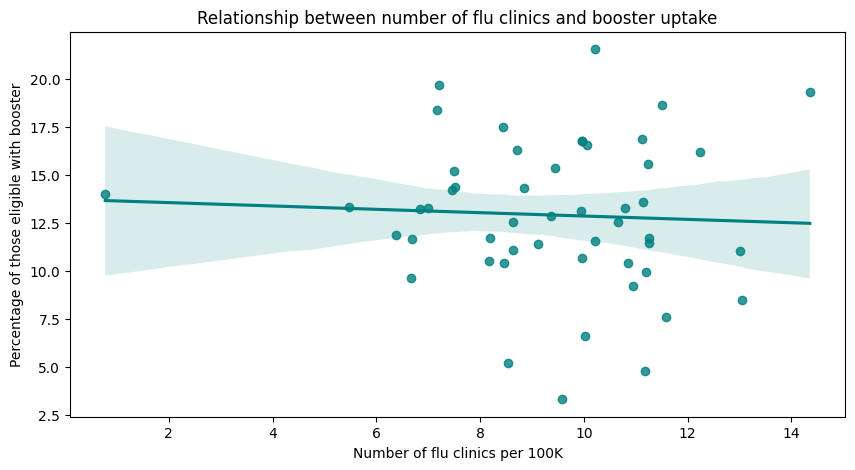

In [24]:
##This figure does not account for any covariates

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.regplot(data=state_vax, x="Clinics_100K", y="Elig_Pct", color="Teal")
ax.set(
    xlabel="Number of flu clinics per 100K",
    ylabel="Percentage of those eligible with booster",
)
ax.set(title="Relationship between number of flu clinics and booster uptake")

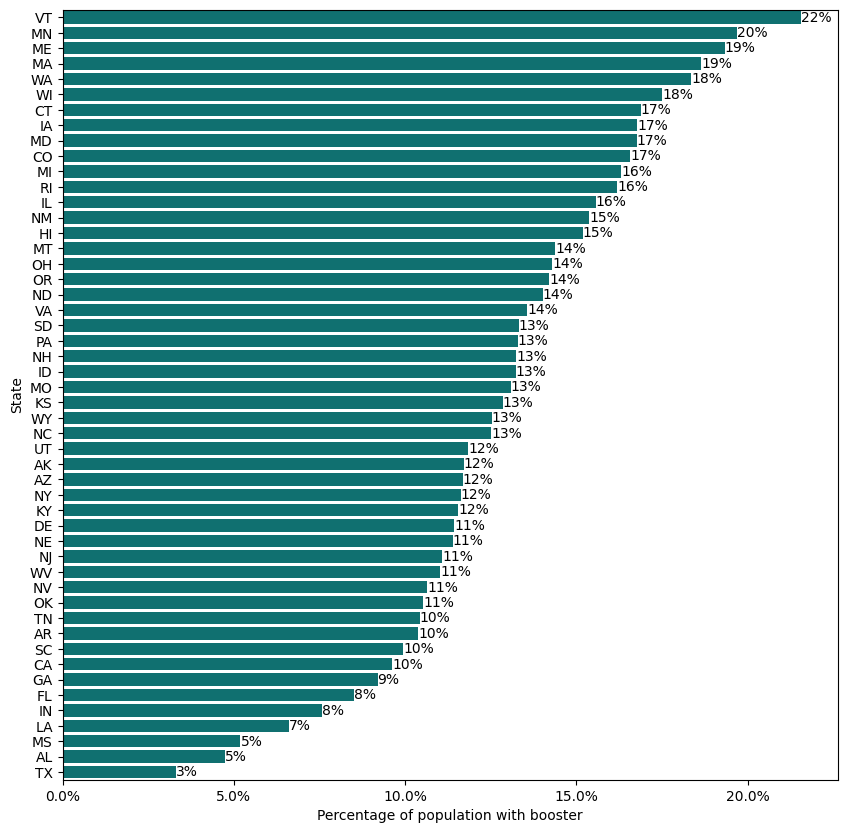

In [25]:
## Vaccine Uptake

vacc_up = df_final

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

sns.barplot(
    data=state_vax,
    x="Elig_Pct",
    y="Location",
    order=df_final.sort_values("Elig_Pct", ascending=False).Location,
    color="Teal",
)

ax.set(ylabel="State", xlabel="Percentage of population with booster")
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for container in ax.containers:
    ax.bar_label(container, fmt="%.f%%")

### OLS Multivariable Regression

In [26]:
## Multivariate analysis

result_all = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + Median_Age + Median_Income + White + Black_or_African_American + American_Indian_and_Alaska_Native + Asian + Native_Hawaiian_and_Other_Pacific_Islander + Some_other_race + Hispanic_or_Latino + Foreign_born_population + High_school_graduate_or_higher + Bachelor_degree_or_higher + FC_2019 + FC_2020 + FC_2021 + R_2016 + R_2020",
    data=state_vax,
).fit()

result_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Elig_Pct   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     7.585
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           5.77e-07
Time:                        17:29:29   Log-Likelihood:                -95.956
No. Observations:                  50   AIC:                             229.9
Df Residuals:                      31   BIC:                             266.2
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      4.5343     43.897      0.103      0.918     -84.993      94.062
Clinics_100K                                   0.0469      0.212      0.221      0.826      -0.385       0.479
Median_Age                                    -0.9521      0.458     -2.079      0.046      -1.886      -0.018
Median_Income                                 -0.0001   9.14e-05     -1.203      0.238      -0.000    7.64e-05
White                                        -13.5834     46.332     -0.293      0.771    -108.079      80.912
Black_or_African_American                    -23.4250     44.564     -0.526      0.603    -114.314      67.464
American_Indian_and_Alaska_Native            -18.8551     57.797     -0.326      0.746    -136.733      99.023
Asian                                         -6.3430     50.434     -0.126      0.901    -109.205      96.519
Native_Hawaiian_and_Other_Pacific_Islander   -81.2267    174.190     -0.466      0.644    -436.490     274.037
Some_other_race                               11.9269     38.049      0.313      0.756     -65.674      89.528
Hispanic_or_Latino                           -14.6652     27.717     -0.529      0.601     -71.195      41.865
Foreign_born_population                      -13.9973     20.571     -0.680      0.501     -55.952      27.957
High_school_graduate_or_higher               106.5053     39.760      2.679      0.012      25.414     187.597
Bachelor_degree_or_higher                     -7.6530     26.295     -0.291      0.773     -61.283      45.977
FC_2019                                       25.4484     18.584      1.369      0.181     -12.455      63.352
FC_2020                                       -8.5721     18.341     -0.467      0.644     -45.979      28.834
FC_2021                                        9.9168     17.166      0.578      0.568     -25.094      44.928
R_2016                                       -23.3588     22.585     -1.034      0.309     -69.421      22.704
R_2020                                         1.4210     27.445      0.052      0.959     -54.554      57.396
==============================================================================
Omnibus:                        1.029   Durbin-Watson:                   1.629
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                0.743
Skew:                          -0.298   Prob(JB):                        0.690
Kurtosis:                       2.967   Cond. No.                     4.59e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.59e+07. This might indicate th

In [27]:
err_series = result_all.params - result_all.conf_int()[0]

In [28]:
coef_df = pd.DataFrame(
    {
        "coef": result_all.params.values[1:],
        "err": err_series.values[1:],
        "varname": err_series.index.values[1:],
    }
)
coef_df

,coef,err,varname
0,0.046883,0.431908,Clinics_100K
1,-0.952082,0.934019,Median_Age
2,-0.000110,0.000186,Median_Income
3,-13.583421,94.495380,White
4,-23.424964,90.888798,Black_or_African_American
5,-18.855052,117.877969,American_Indian_and_Alaska_Native
6,-6.343021,102.861592,Asian
7,-81.226678,355.263714,Native_Hawaiian_and_Other_Pacific_Islander
8,11.926896,77.600757,Some_other_race
9,-14.665238,56.529841,Hispanic_or_Latino


/var/folders/z9/gdw88pxx7pnfg5bk987tzgqh0000gn/T/ipykernel_97404/2327383981.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


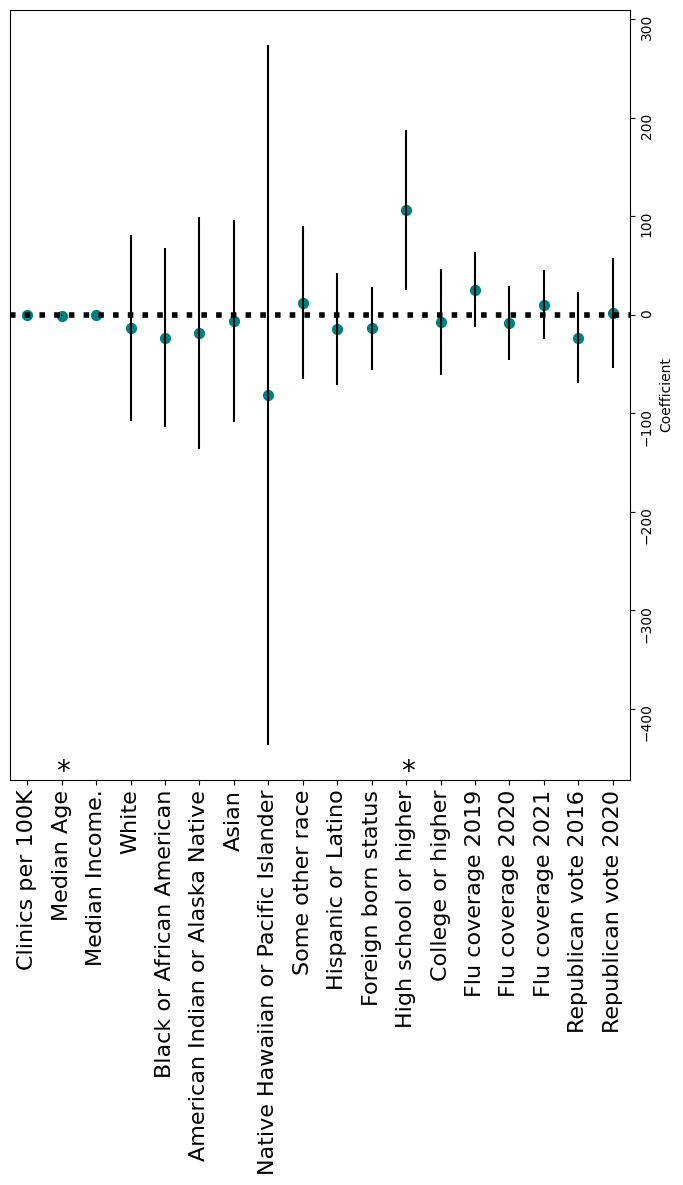

In [29]:
fig, ax = plt.subplots(figsize=(8, 10))
coef_df.plot(
    x="varname", y="coef", kind="bar", ax=ax, color="none", yerr="err", legend=False
)
ax.set_ylabel("Coefficient")
ax.set_xlabel("")
ax.scatter(
    x=pd.np.arange(coef_df.shape[0]), marker="o", s=50, y=coef_df["coef"], color="teal"
)
ax.axhline(y=0, linestyle=":", color="black", linewidth=4)
ax.set_xticklabels(
    [
        "Clinics per 100K",
        "Median Age",
        "Median Income.",
        "White",
        "Black or African American",
        "American Indian or Alaska Native",
        "Asian",
        "Native Hawaiian or Pacific Islander",
        "Some other race",
        "Hispanic or Latino",
        "Foreign born status",
        "High school or higher",
        "College or higher",
        "Flu coverage 2019",
        "Flu coverage 2020",
        "Flu coverage 2021",
        "Republican vote 2016",
        "Republican vote 2020",
    ],
    rotation=90,
    fontsize=16,
)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.setp(ax.get_yticklabels(), rotation=90)
for x in [0.85, 10.85]:
    ax.text(x, 0, "*", fontsize=20, transform=ax.get_xaxis_transform())

In [30]:
params = result_all.params
conf = result_all.conf_int()
conf["Odresult_alls Ratio"] = params
conf.columns = ["2.5%", "97.5%", "Odds Ratio"]

ols = pd.DataFrame(np.exp(conf))

ols["pvalues"] = result_all.pvalues
ols["significant?"] = [
    "significant" if pval <= 0.05 else "not significant" for pval in result_all.pvalues
]
ols

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Intercept,1.224422e-37,7.088132e+40,9.316040e+01,0.918394,not significant
Clinics_100K,6.804341e-01,1.614122e+00,1.048000e+00,0.826242,not significant
Median_Age,1.516621e-01,9.820991e-01,3.859368e-01,0.045986,significant
Median_Income,9.997038e-01,1.000076e+00,9.998901e-01,0.238138,not significant
White,1.153382e-47,1.379168e+35,1.261233e-06,0.771343,not significant
Black_or_African_American,2.260291e-50,1.991456e+29,6.709151e-11,0.602873,not significant
American_Indian_and_Alaska_Native,4.145755e-60,1.011827e+43,6.476718e-09,0.746444,not significant
Asian,3.741445e-48,8.269567e+41,1.758981e-03,0.900728,not significant
Native_Hawaiian_and_Other_Pacific_Islander,2.720390e-190,1.029847e+119,5.292999e-36,0.644254,not significant
Some_other_race,3.007493e-29,7.609667e+38,1.512813e+05,0.756027,not significant


In [31]:
# forest plot =

### OLS Bivariable Regressions

In [32]:
## Median Age bivariable analysis

result_age = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + Median_Age",
    data=state_vax,
).fit()

print(result_age.summary())

                            OLS Regression Results                            
Dep. Variable:               Elig_Pct   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     4.645
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0144
Time:                        17:29:29   Log-Likelihood:                -133.63
No. Observations:                  50   AIC:                             273.3
Df Residuals:                      47   BIC:                             279.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -15.6447      9.955     -1.572   

In [33]:
## Median income bivariable analysis

result_income = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + Median_Income",
    data=state_vax,
).fit()

print(result_income.summary())

                            OLS Regression Results                            
Dep. Variable:               Elig_Pct   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     6.484
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00326
Time:                        17:29:29   Log-Likelihood:                -132.04
No. Observations:                  50   AIC:                             270.1
Df Residuals:                      47   BIC:                             275.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5871      3.992      0.398

In [34]:
## High school education level bivariable analysis

result_income = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + High_school_graduate_or_higher",
    data=state_vax,
).fit()

print(result_income.summary())

                            OLS Regression Results                            
Dep. Variable:               Elig_Pct   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     23.80
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           7.25e-08
Time:                        17:29:29   Log-Likelihood:                -120.65
No. Observations:                  50   AIC:                             247.3
Df Residuals:                      47   BIC:                             253.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [35]:
## College education level bivariable analysis

result_income = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + Bachelor_degree_or_higher",
    data=state_vax,
).fit()

print(result_income.summary())

                            OLS Regression Results                            
Dep. Variable:               Elig_Pct   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     14.21
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.49e-05
Time:                        17:29:29   Log-Likelihood:                -126.31
No. Observations:                  50   AIC:                             258.6
Df Residuals:                      47   BIC:                             264.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [36]:
## Past flu coverage bivariable analysis

result_income = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + FC_2021",
    data=state_vax,
).fit()

print(result_income.summary())

                            OLS Regression Results                            
Dep. Variable:               Elig_Pct   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     22.21
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.62e-07
Time:                        17:29:29   Log-Likelihood:                -121.50
No. Observations:                  50   AIC:                             249.0
Df Residuals:                      47   BIC:                             254.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.0268      3.558     -1.975   

In [37]:
## Race-ethnicity bivariable analysis

result_income = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + White",
    data=state_vax,
).fit()

print(result_income.summary())

                            OLS Regression Results                            
Dep. Variable:               Elig_Pct   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3.041
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0573
Time:                        17:29:29   Log-Likelihood:                -135.09
No. Observations:                  50   AIC:                             276.2
Df Residuals:                      47   BIC:                             281.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.6519      3.349      2.285   

In [38]:
## Republican voting bivariable analysis

result_income = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + R_2020",
    data=state_vax,
).fit()

print(result_income.summary())

                            OLS Regression Results                            
Dep. Variable:               Elig_Pct   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     8.858
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           0.000544
Time:                        17:29:29   Log-Likelihood:                -130.14
No. Observations:                  50   AIC:                             266.3
Df Residuals:                      47   BIC:                             272.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.9118      3.354      7.428   